# Convolutional Neural Network

### CNN Generation

Loading NumPy Data...
Train:          (25892, 260, 320, 3), (25892, 2)
Validation:     (6473, 260, 320, 3), (6473, 2)
Test:           (8092, 260, 320, 3), (8092, 2)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saving Best Model with Accuracy: 95.20%

Epoch 2/25


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/25


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/25


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/25
Saving Best Model with Accuracy: 99.12%

Epoch 6/25
Saving Best Model with Accuracy: 99.86%

Epoch 7/25
Saving Best Model with Accuracy: 99.97%

Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
Best model saved at: /content/drive/MyDrive/GradProjectFiles/ModelSaves/bestModel_2025-03-02.pth



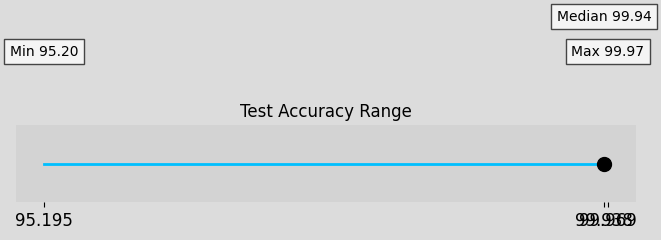

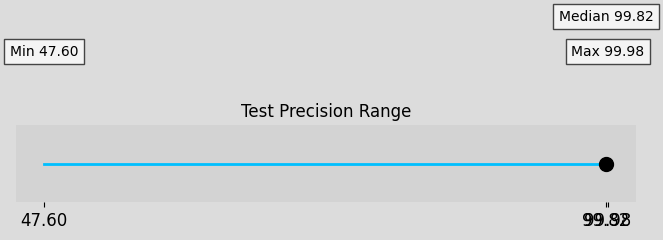

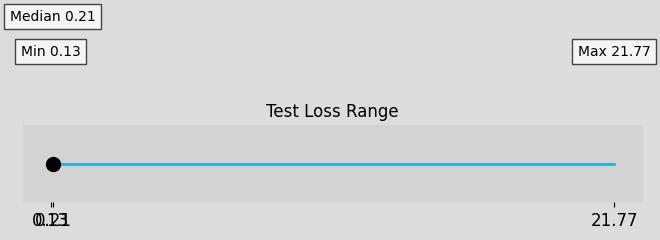


Finished Training...


In [1]:
import os
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set debug flag if needed
DEBUG = False

if DEBUG:
    print("-- Debugging Enabled --\n")

numpySaves = "/content/drive/MyDrive/GradProjectFiles/NumPyDataSaves"
modelSaves = "/content/drive/MyDrive/GradProjectFiles/ModelSaves"

os.makedirs(modelSaves, exist_ok=True)

allResults = []
_currentDateTime = datetime.datetime.now().strftime("%Y-%m-%d")

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images.float() / 255.0
        self.labels = labels.long()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].permute(2, 0, 1)
        label = self.labels[idx]

        return image, label

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # ✅ Change 1 → 3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 65 * 80, 512)  # Adjusted for (260, 320) input size
        self.fc2 = nn.Linear(512, 27)  # Adjust output size to match the number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # ✅ Correct flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def validate(model, validate_loader, criterion):
    model.eval()
    validate_loss = 0.0
    validate_correct = 0
    validate_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in validate_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels.argmax(dim=1))  # Compute loss
            validate_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            validate_total += labels.size(0)
            validate_correct += (predicted == labels.argmax(dim=1)).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.argmax(dim=1).cpu().numpy())

    accuracy = 100 * validate_correct / validate_total
    avg_loss = validate_loss / len(validate_loader)

    precision = precision_score(all_labels, all_predictions, average='macro')

    return accuracy, avg_loss, precision

def plotGraphsAndRanges(allResults, bg_color="lightgray"):
    if not allResults:
        print("No results to display.")
        return

    # Extract and round values
    accuracies = [round(result[0] * 100, 8) for result in allResults]
    precisions = [round(result[2] * 100, 4) for result in allResults]
    losses = [round(result[1] * 100, 4) for result in allResults]

    metrics = {
        "Test Accuracy": accuracies,
        "Test Precision": precisions,
        "Test Loss": losses
    }

    for title, values in metrics.items():
        if not values:
            continue

        minValue = min(values)
        maxValue = max(values)
        medianValue = sorted(values)[len(values) // 2]

        fig, ax = plt.subplots(figsize=(8, 1))
        fig.patch.set_facecolor('gainsboro')  # Set figure background
        ax.set_facecolor(bg_color)  # Set plot background

        ax.plot([minValue, maxValue], [1, 1], color='deepskyblue', lw=2)  # Range line
        ax.plot(medianValue, 1, 'ko', ms=10)  # Median point

        ax.set_yticks([])
        ax.set_xticks([minValue, medianValue, maxValue])
        ax.tick_params(axis='x', which='major', labelsize=12)

        ax.text(minValue, 1.15, f'Min {minValue:.2f}', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.7))
        ax.text(medianValue, 1.2, f'Median {medianValue:.2f}', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.7))
        ax.text(maxValue, 1.15, f'Max {maxValue:.2f}', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

        ax.set_title(f'{title} Range')

        # Remove all spines for a clean look
        for spine in ax.spines.values():
            spine.set_visible(False)

        plt.show()
        print()

if __name__ == '__main__':
    # Load the numpy dataset
    print("Loading NumPy Data...")
    trainImages = np.load(os.path.join(numpySaves, "trainImages.npz"))['arr_0']
    trainLabels = np.load(os.path.join(numpySaves, "trainLabels.npz"))['arr_0']
    valImages = np.load(os.path.join(numpySaves, "valImages.npz"))['arr_0']
    valLabels = np.load(os.path.join(numpySaves, "valLabels.npz"))['arr_0']
    testImages = np.load(os.path.join(numpySaves, "testImages.npz"))['arr_0']
    testLabels = np.load(os.path.join(numpySaves, "testLabels.npz"))['arr_0']

    print(f"Train:          {trainImages.shape}, {trainLabels.shape}")
    print(f"Validation:     {valImages.shape}, {valLabels.shape}")
    print(f"Test:           {testImages.shape}, {testLabels.shape}")
    print()

    #convert numpy arrays to PyTorch tensors
    trainImagesTensor = torch.tensor(trainImages, dtype=torch.float32)
    trainLabelsTensor = torch.tensor(trainLabels, dtype=torch.long)
    valImagesTensor = torch.tensor(valImages, dtype=torch.float32)
    valLabelsTensor = torch.tensor(valLabels, dtype=torch.long)
    testImagesTensor = torch.tensor(testImages, dtype=torch.float32)
    testLabelsTesnor = torch.tensor(testLabels, dtype=torch.long)

    #create dataset and data loaders for training, validation, and test data
    trainDataset = CustomDataset(trainImagesTensor, trainLabelsTensor)
    validateDataset = CustomDataset(valImagesTensor, valLabelsTensor)
    testDataset = CustomDataset(testImagesTensor, testLabelsTesnor)

    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=64, shuffle=True)
    validateLoader = torch.utils.data.DataLoader(validateDataset, batch_size=64, shuffle=False)
    testLoader = torch.utils.data.DataLoader(testDataset, batch_size=64, shuffle=False)

    #initialize the model
    model = CNN()

    #define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize the best model globally
    bestModel = CNN()  # Prevents NoneType error
    bestModel.load_state_dict(model.state_dict())

    #training the model
    numEpochs = 25
    maxAccuracy = 0

    for epoch in range(numEpochs):
        print(f"Epoch {epoch + 1}/{numEpochs}")
        model.train()
        running_loss = 0.0

        for i, data in enumerate(trainLoader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                if DEBUG:
                    print(f"[Epoch: {epoch + 1}, Batch: {i + 1}] Loss: {running_loss / 100:.4f}")
                running_loss = 0.0

        # Validate after each epoch
        accuracy, avg_loss, precision = validate(model, validateLoader, criterion)
        allResults.append((accuracy / 100, avg_loss, precision))  # Normalize accuracy to (0,1) range

        if accuracy > maxAccuracy:
            bestModel.load_state_dict(model.state_dict())  # Copy model weights
            maxAccuracy = accuracy
            print(f"Saving Best Model with Accuracy: {accuracy:.2f}%\n")

    bestModelPath = os.path.join(modelSaves, f"bestModel_{_currentDateTime}.pth")
    torch.save(bestModel.state_dict(), bestModelPath)
    print(f"Best model saved at: {bestModelPath}\n")

    plotGraphsAndRanges(allResults)
    print("Finished Training...")